# Augur - cell type prioritization prediction

This is a short tutorial demonstrating Augur, a Python implementation of the [Augur R package](https://github.com/neurorestore/Augur).

Augur aims to rank or prioritize cell types according to their response to experimental perturbations.
The fundamental idea is that in the space of molecular measurements cells reacting heavily to induced perturbations are more easily separated into perturbed and unperturbed than cell types with little or no response.
This separability is quantified by measuring how well experimental labels (e.g. treatment and control) can be predicted within each cell type.
Augur trains a machine learning model predicting experimental labels for each cell type in multiple cross validation runs and then prioritizes cell type response according to metric scores measuring the accuracy of the model.
For categorical data Augur uses the area under the curve and for numerical data it uses concordance correlation coefficient.

The following tutorial runs through a simple analysis with Augur using a simulated dataset.

## Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pertpy as pt
import scanpy as sc

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

As a first step, we load the dataset.
This can either be an AnnData object, a DataFrame containing cell type labels as well as conditions for each cell or data contained in a DataFrame that contains the corresponding metadata.

Afterwards, we create an Augur object specifying our estimator of interest to measure how predictable the perturbation labels for each cell type in the dataset are. Choose `random_forest_classifier` or `logistic_regression_classifier` for categorical data and `random_forest_regressor` for numerical data.
Additional parameters can be added through the `Params` class.

Next, load this data into an AnnData object adding dummy variables of labels and renaming cell type and label observation columns to `cell_type` and `label`.

The dataset that we'll use consists of 600 cells, distributed evenly between three populations (cell types A, B, and C).
Each of these cell types has approximately half of its cells in one of two conditions, treatment and control.
The cell types also have different numbers of differentially expressed genes (DEG) in response to treatment.
Cell type A has approximately 5% of DEG in response to the treatment, while cell type B has 25% DEGs and cell type C has 50%. 

In [3]:
adata = pt.dt.sc_sim_augur()

ag_rfc = pt.tl.Augur("random_forest_classifier")
loaded_data = ag_rfc.load(adata)

In [4]:
loaded_data

AnnData object with n_obs × n_vars = 600 × 15697
    obs: 'label', 'cell_type', 'y_'
    var: 'name'

## Augur prediction

Now we run Augur with the function `predict` and look at the results:

The default way to select features is based on `select_variance`, which is an implementation that is very close to the original R Augur implementation. In addition, it is possible to select features with `scanpy.pp.highly_variable_genes`, by setting `select_variance_features=False`

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
To use sccoda or tasccoda please install ete3 with pip install ete3
To use sccoda or tasccoda please install ete3 with pip install ete3
To use sccoda or tasccoda please install ete3 with pip install ete3
To use sccoda or tasccoda please install ete3 with pip install ete3


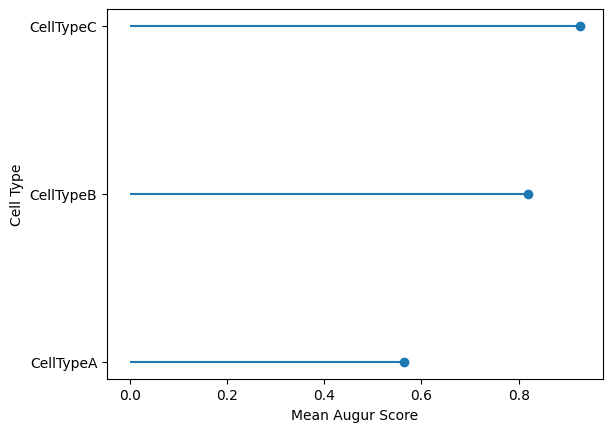

In [5]:
v_adata, v_results = ag_rfc.predict(loaded_data, subsample_size=20, select_variance_features=True, n_threads=4)

# to visualize the results
lollipop = pt.pl.ag.lollipop(v_results)

In [6]:
h_adata, h_results = ag_rfc.predict(loaded_data, subsample_size=20, select_variance_features=False, n_threads=4)

print(h_results["summary_metrics"])

Output()

ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
To use sccoda or tasccoda please install ete3 with pip install ete3
ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
To use sccoda or tasccoda please install ete3 with pip install ete3
ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.
To use sccoda or tasccoda please install ete3 with pip install ete3


                  CellTypeA  CellTypeB  CellTypeC
mean_augur_score   0.598299   0.867948   0.918435
mean_auc           0.598299   0.867948   0.918435
mean_accuracy      0.542674   0.735971   0.783040
mean_precision     0.539211   0.782898   0.790340
mean_f1            0.419785   0.697024   0.795674
mean_recall        0.418889   0.704921   0.855873


Here we visualize the cell ranking and the corresponding augur scores using `select variance` feature selection in a lollipop plot.
In this case the ranking it the same but the values themselves differ between the two methods. 

To compare the two feature selection methods they can be plotted together in a scatterplot. Here you can see that CellTypeB has slightly higher values when using the method `select_highly_variable` compared to `select_variance`, where as CellTypeC has the same augur score.

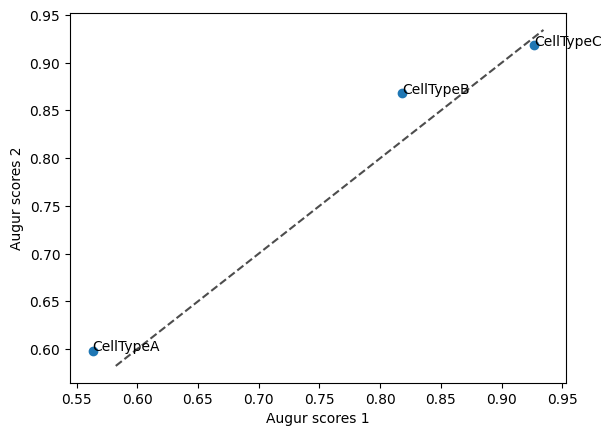

In [7]:
scatter = pt.pl.ag.scatterplot(v_results, h_results)

The corresponding `mean_augur_score` is also saved in `result_adata.obs`.

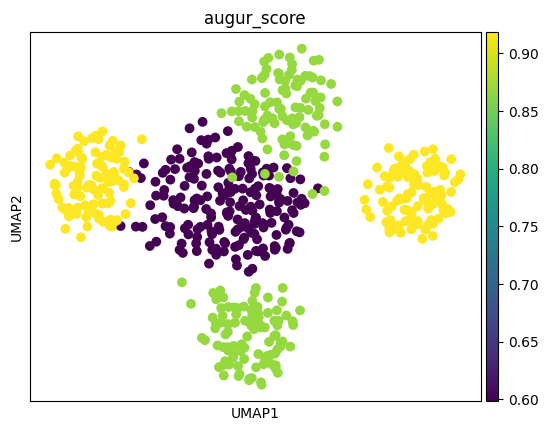

In [8]:
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)
sc.pl.umap(adata=v_adata, color="augur_score")

### Feature Importances

The results object also returns feature importances.
In the case of a random forest estimator the feature importances built into sci-kit learn were used to calculate feature importances.
For the logistic regression the [agresti method](https://think-lab.github.io/d/205/) is used where the mean gets subtracted from the coefficient values and then divided by the standard deviation.

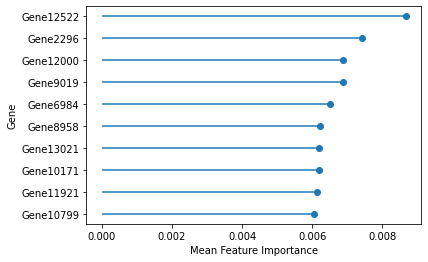

In [9]:
important_features = pt.pl.ag.important_features(v_results)

### Differential Prioritization

Augur is also able to perform differential prioritization and executes a permutation test to identify cell types with statistically significant differences in AUC between two different rounds of cell type prioritization (e.g. response to drugs A and B, compared to untreated control). 

In the following part, single-cell prefrontal cortex data from adult mice under cocaine self-administration from [Bhattacherjee 2019](https://doi.org/10.1038/s41467-019-12054-3) will be used.
Adult mice were subject to cocaine self-administration, samples were collected after three time points: Maintenance, 48h after cocaine withdrawal and 15 days after cocaine withdrawal.

We compare `withdraw_15d_Cocaine` and `withdraw_48h_Cocaine` with respect to the difference to `Maintenance_Cocaine`.
Each variation is run once in default mode and once in permute mode.

In [10]:
bhattacherjee_adata = pt.dt.bhattacherjee()
ag_rfc = pt.tl.Augur("random_forest_classifier")

We first run Augur on `Maintenance_Cocaine` and `withdraw_15d_Cocaine` in `augur_mode`=`default`  and `augur_mode`=`permute` mode. 

In [11]:
# default
bhattacherjee_15 = ag_rfc.load(
    bhattacherjee_adata,
    condition_label="Maintenance_Cocaine",
    treatment_label="withdraw_15d_Cocaine",
)

bhattacherjee_adata_15, bhattacherjee_results_15 = ag_rfc.predict(bhattacherjee_15, random_state=None, n_threads=4)

print(bhattacherjee_results_15["summary_metrics"].loc["mean_augur_score"].sort_values(ascending=False))

Filtering samples with Maintenance_Cocaine and withdraw_15d_Cocaine labels.

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Oligo         0.916088
Astro         0.912823
Microglia     0.907143
OPC           0.900397
Endo          0.780590
Excitatory    0.688617
NF Oligo      0.678730
Inhibitory    0.660023
Name: mean_augur_score, dtype: float64


In [12]:
# permute
bhattacherjee_adata_15_permute, bhattacherjee_results_15_permute = ag_rfc.predict(
    bhattacherjee_15,
    augur_mode="permute",
    n_subsamples=100,
    random_state=None,
    n_threads=4,
)

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Now lets do the same looking at `Maintenance_Cocaine` and `withdraw_48h_Cocaine`.

In [13]:
# default
bhattacherjee_48 = ag_rfc.load(
    bhattacherjee_adata,
    condition_label="Maintenance_Cocaine",
    treatment_label="withdraw_48h_Cocaine",
)

bhattacherjee_adata_48, bhattacherjee_results_48 = ag_rfc.predict(bhattacherjee_48, random_state=None, n_threads=4)

print(bhattacherjee_results_48["summary_metrics"].loc["mean_augur_score"].sort_values(ascending=False))

Filtering samples with Maintenance_Cocaine and withdraw_48h_Cocaine labels.

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Inhibitory    0.675272
Astro         0.664728
OPC           0.628141
Microglia     0.614116
Endo          0.603107
Oligo         0.589728
NF Oligo      0.587596
Excitatory    0.559229
Name: mean_augur_score, dtype: float64


In [14]:
# permute
bhattacherjee_adata_48_permute, bhattacherjee_results_48_permute = ag_rfc.predict(
    bhattacherjee_48,
    augur_mode="permute",
    n_subsamples=100,
    random_state=None,
    n_threads=4,
)

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Skipping NF Oligo cell type - 79 samples is less than min_cells 100.

Let's also take a look at the Augur scores of the two versions in a scatter plot. The diagonal line is the identity function. If the values were the same they would be on the line. 

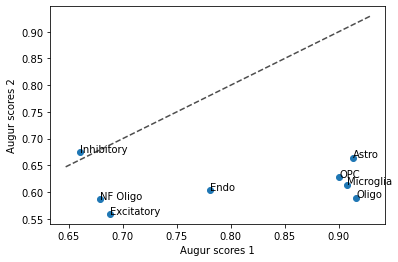

In [15]:
scatter = pt.pl.ag.scatterplot(bhattacherjee_results_15, bhattacherjee_results_48)

To figure out which cell type was most affected in comparing `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine` we can run differential prioritization:

In [16]:
pvals = ag_rfc.predict_differential_prioritization(
    augur_results1=bhattacherjee_results_15,
    augur_results2=bhattacherjee_results_48,
    permuted_results1=bhattacherjee_results_15_permute,
    permuted_results2=bhattacherjee_results_48_permute,
)

In [17]:
pvals

,cell_type,mean_augur_score1,mean_augur_score2,delta_augur,b,m,z,pval,padj
0,Microglia,0.907143,0.614116,-0.293027,1000,1000,-20.449195,0.001998,0.002331
1,Endo,0.780590,0.603107,-0.177483,1000,1000,-8.876841,0.001998,0.002331
2,Astro,0.912823,0.664728,-0.248095,1000,1000,-16.247874,0.001998,0.002331
3,OPC,0.900397,0.628141,-0.272256,788,1000,-18.572921,0.425574,0.425574
4,Inhibitory,0.660023,0.675272,0.015249,1000,1000,3.218067,0.001998,0.002331
5,Excitatory,0.688617,0.559229,-0.129388,1000,1000,-9.034865,0.001998,0.002331
6,Oligo,0.916088,0.589728,-0.326361,1000,1000,-19.445162,0.001998,0.002331


The p-value, following the R Augur implementation is calculated using `b`, the number of times permuted values are larger than original values and `m`, the number of permutations run. Since `b` is the same for all cells but OPC, the p-value is the same for these as well.

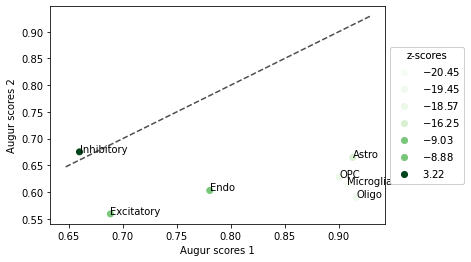

In [18]:
diff = pt.pl.ag.dp_scatter(pvals)

In this case the cell type Microglia has the lowest z-score. When comparing the impact of `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine`, this cell type was most perturbed. 

## Conclusion

Augur is a simple way of ranking perturbation effects based on the idea that stronger perturbations should be easier separable from control than weaker perturbations.

## References

1. Skinnider, M.A., Squair, J.W., Kathe, C. et al. Cell type prioritization in single-cell data. Nat Biotechnol 39, 30–34 (2021). https://doi.org/10.1038/s41587-020-0605-1
2. Squair, J.W., Skinnider, M.A., Gautier, M. et al. Prioritization of cell types responsive to biological perturbations in single-cell data with Augur. Nat Protoc 16, 3836–3873 (2021). https://doi.org/10.1038/s41596-021-00561-x
3. Bhattacherjee, A., Djekidel, M.N., Chen, R. et al. Cell type-specific transcriptional programs in mouse prefrontal cortex during adolescence and addiction. Nat Commun 10, 4169 (2019). https://doi.org/10.1038/s41467-019-12054-3